In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

play_data = pd.read_csv('./data/plays.csv')
pff_data = pd.read_csv('./data/PFFScoutingData.csv')

discard_results = ['Non-Special Teams Result']#,'Blocked Punt']
punt_plays = play_data[(play_data['specialTeamsPlayType']=='Punt')&(~play_data['specialTeamsResult'].isin(discard_results))]
pff_punt = pff_data.merge(punt_plays[['gameId','playId']],on=['gameId','playId'],how='inner')

inplay_fbland = pd.read_csv('./ReducedData/BounceCatch.csv')
print(len(inplay_fbland))

snap_frame = pd.read_csv('./ReducedData/snapframe.csv')
snap_frame.rename({'snap_frame':'frameId'},axis=1,inplace=True)
max_frame = max(snap_frame['frameId'])
print(max_frame)

5514
16


In [2]:
# Pulling out specific tracking data:
# We are interested in finding the positions of particular players at the snap frame
# First, we only keep frames before the latest snap frame occurs
# Then, further reduce the tracking data by keeping only the Punts we are interested in and only the snap frame data.

# 2018 Football Tracking Data
tracking_game = pd.read_csv('./data/tracking2018.csv', chunksize=10**5)
football_tracking = pd.concat((x.query("frameId <= @max_frame") for x in tracking_game), ignore_index=True)
punt_fbtrack_18 = football_tracking.merge(punt_plays[['gameId','playId']],on=['gameId','playId']).merge(snap_frame)
punt_fbtrack_18['time'] = pd.to_datetime(punt_fbtrack_18['time'])

# 2019 Football Tracking Data
tracking_game = pd.read_csv('./data/tracking2019.csv', chunksize=10**5)
football_tracking = pd.concat((x.query("frameId <= @max_frame") for x in tracking_game), ignore_index=True)
punt_fbtrack_19 = football_tracking.merge(punt_plays[['gameId','playId']],on=['gameId','playId']).merge(snap_frame)
punt_fbtrack_19['time'] = pd.to_datetime(punt_fbtrack_19['time'])

# 2020 Football Tracking Data
tracking_game = pd.read_csv('./data/tracking2020.csv', chunksize=10**5)
football_tracking = pd.concat((x.query("frameId <= @max_frame") for x in tracking_game), ignore_index=True)
punt_fbtrack_20 = football_tracking.merge(punt_plays[['gameId','playId']],on=['gameId','playId']).merge(snap_frame)
punt_fbtrack_20['time'] = pd.to_datetime(punt_fbtrack_20['time'])

# Combine all above tracking data
track_snap = pd.concat([punt_fbtrack_18,punt_fbtrack_19,punt_fbtrack_20]) \
                .sort_values(by=['gameId','playId','frameId']) \
                .drop(columns=['s','a','dis','event','frameId','displayName','jerseyNumber']) \
                .reset_index(drop=True)

inplay_track_snap = track_snap.merge(inplay_fbland[['gameId','playId']])

## Flip tracking data so all the plays are 'right'-sided kicks (towards larger values of x)

In [3]:
# We want to preserve the handedness of plays and players when flipping the tracking data
# We want to transform plays where playDirection == 'left'
# Reflect the x and y position, and rotate orientation and direction.

def flip_play_direction(df):
    df_flipped = df.copy()
    df_flipped['to_flip'] = (df['playDirection']=='left')
    
    df_flipped['x'] = df_flipped['x']*(1-df_flipped['to_flip']) + (120-df_flipped['x'])*(df_flipped['to_flip'])
    df_flipped['y'] = df_flipped['y']*(1-df_flipped['to_flip']) + (160/3-df_flipped['y'])*(df_flipped['to_flip'])
    
    # When orientation of players is included, flipping field is equal to a 180 degree rotation.
    # Mod by 360 degrees to keep values in the range [0,360)
    orientation_cols = [col for col in df_flipped.columns if col in ['o','dir']]
    for col in orientation_cols:
        df_flipped[col] = (180*(df_flipped['to_flip']) + df_flipped[col])%360

    return df_flipped.drop(columns=['to_flip'])

In [4]:
fbland_f = flip_play_direction(inplay_fbland) # Inplay football landing data flipped
snap_track_f = flip_play_direction(inplay_track_snap) # Inplay tracking flipped for snap-frame data

#### Separate the football fame 1 data from the players.

In [5]:
fb_snap = snap_track_f[snap_track_f['team']=='football'].copy() # Football
player_snap = snap_track_f[snap_track_f['team'].isin(['home','away'])] # Players at snap frame

## Find specific players for punt plays (punter, returner, gunners, jammers)

In the data, the punter is always either a punter of kicker (position of 'P' or 'K').

Traditionally, there is one returner who is far off the line of scrimmage.  Some plays will not have a designated returner, but we will still classify one player as a returner; the one most removed from the line of scrimmage.

Note, there are 41 plays with 2 punt returners.  There are two ways that we can address this issue.

1) Use the football landing information to find which is the true returner.  If the ball bounces, we will use the 2nd option always.

2) Create a data point for each returner, doubling up on the ball landing, etc., variables.  Each returner's decision can be evaluated by the neural network.  Note this will have the inherent issue where at least one returner cannot catch the ball.  Therefore, even a ball that would be easy and ideal for each returner to grab will push the network towards less catches.

#### Punter

Also separate the respective teams

In [6]:
punter = player_snap[player_snap['position'].isin(['P','K'])].sort_values('x',ascending=False).groupby(['gameId','playId']).last().reset_index()
temp = player_snap.merge(punter[['gameId','playId','team']],on=['gameId','playId'],suffixes=('','_punt'))
punt_team = temp[temp['team']==temp['team_punt']].copy()
rec_team = temp[temp['team']!=temp['team_punt']].copy()

#### Football at/before snap

,gameId,playId,x_fb,y_fb
0,2018090600,366,18,29.940000
1,2018090600,872,45,29.950000
2,2018090600,973,21,29.880000
3,2018090600,1850,41,23.363333
4,2018090600,1989,36,23.790000
...,...,...,...,...
5509,2021010315,1359,30,29.573333
5510,2021010315,1479,33,26.690000
5511,2021010315,2235,37,23.840000
5512,2021010315,2497,36,23.850000


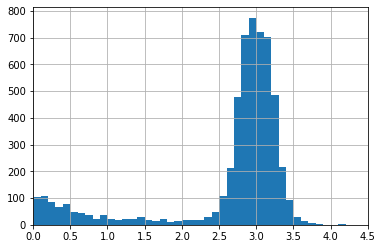

In [7]:
football_loc = fb_snap[['gameId','playId','x','y','playDirection']].merge(punt_plays[['gameId','playId','absoluteYardlineNumber']]) \
                    .rename({'absoluteYardlineNumber':'x_yl'},axis=1)
football_loc['x_yl'] += (football_loc['playDirection']=='left')*(120-2*football_loc['x_yl'])
fb_loc = football_loc[['gameId','playId','x_yl','y']].rename({'x_yl':'x_fb','y':'y_fb'},axis=1)
display(fb_loc)

np.abs(fb_snap['y']-80/3).hist(bins=np.arange(0,5,0.1))
plt.xlim(0,4.5)
plt.show()

### All Players

In [8]:
no_punter = punt_team.merge(punter,how='left',indicator=True).query('_merge=="left_only"').drop(columns = ['_merge'])[['gameId','playId','x','y']].copy()
no_punter['num'] = no_punter.groupby(['gameId','playId']).cumcount()
punt_team_pos = pd.pivot_table(no_punter,values=['x','y'],index=['gameId','playId'],columns='num')
punt_team_pos.columns  = [f'x_p{i}' for i in range(10)] + [f'y_p{i}' for i in range(10)]
punt_team_pos = punt_team_pos[[punt_team_pos.columns[i] for i in np.array([[j, j+10] for j in range(10)]).reshape((20,))]].reset_index().round(2)
punt_team_pos

,gameId,playId,x_p0,y_p0,x_p1,y_p1,x_p2,y_p2,x_p3,y_p3,...,x_p5,y_p5,x_p6,y_p6,x_p7,y_p7,x_p8,y_p8,x_p9,y_p9
0,2018090600,366,13.76,31.14,16.39,27.64,16.76,31.01,17.49,29.97,...,16.51,32.14,17.02,47.57,17.09,29.37,14.79,26.57,17.06,6.16
1,2018090600,872,40.72,31.18,43.45,27.64,43.96,31.23,44.35,30.05,...,43.48,32.14,43.65,46.60,44.09,29.15,41.15,26.63,43.86,6.75
2,2018090600,973,19.74,5.97,17.61,27.96,16.04,28.64,20.49,29.55,...,19.68,28.74,17.67,31.84,19.37,30.71,19.83,46.06,19.36,28.08
3,2018090600,1850,36.54,24.87,39.51,21.07,39.64,24.48,40.28,23.31,...,39.21,25.59,39.96,46.29,39.66,22.50,37.14,20.16,39.65,7.80
4,2018090600,1989,35.09,6.01,32.44,21.67,30.72,22.42,35.47,23.74,...,34.64,22.93,32.63,25.86,34.44,24.58,34.99,43.26,34.33,22.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5509,2021010315,1359,26.04,26.90,29.06,44.17,24.93,28.06,28.54,27.94,...,29.38,29.52,26.37,31.64,28.41,28.66,28.15,31.20,29.29,9.91
5510,2021010315,1479,31.31,25.71,29.25,29.00,32.20,26.49,31.46,24.41,...,27.33,27.93,31.77,9.51,31.70,27.50,31.46,28.51,32.32,45.50
5511,2021010315,2235,35.07,22.98,32.97,26.20,35.80,23.83,34.75,21.93,...,30.64,25.15,35.56,7.89,35.20,24.70,34.99,25.74,35.38,45.24
5512,2021010315,2497,33.98,22.88,31.73,26.42,34.75,23.83,33.54,21.75,...,29.71,25.49,34.19,7.01,34.07,24.70,33.84,25.90,34.37,45.55


In [9]:
test = rec_team[['gameId','playId','x','y']].copy()
test['num'] = test.groupby(['gameId','playId']).cumcount()
rec_pos = pd.pivot_table(test,index=['gameId','playId'],columns='num',values=['x','y'])
rec_pos.columns = [f'x_r{i}' for i in range(11)] + [f'y_r{i}' for i in range(11)]
rec_pos = rec_pos[[rec_pos.columns[i] for i in np.array([[j, j+11] for j in range(11)]).reshape((22,))]].reset_index().round(2)
rec_pos

,gameId,playId,x_r0,y_r0,x_r1,y_r1,x_r2,y_r2,x_r3,y_r3,...,x_r6,y_r6,x_r7,y_r7,x_r8,y_r8,x_r9,y_r9,x_r10,y_r10
0,2018090600,366,18.54,33.06,19.00,5.47,18.71,25.62,67.05,26.31,...,18.65,29.03,18.27,26.84,20.12,31.29,18.75,49.00,18.41,33.63
1,2018090600,872,45.31,33.84,45.95,5.81,45.54,28.42,47.65,31.10,...,45.32,26.70,45.41,23.61,45.48,35.27,47.21,46.33,45.17,31.24
2,2018090600,973,68.89,34.84,20.68,31.90,21.27,31.04,21.06,35.38,...,21.23,33.68,21.44,27.84,21.25,26.11,21.49,25.32,21.77,6.36
3,2018090600,1850,41.61,26.42,41.60,7.86,41.78,21.66,85.48,20.91,...,41.91,19.96,42.15,17.65,41.78,28.36,42.79,46.11,41.65,24.46
4,2018090600,1989,85.21,28.81,36.94,24.54,36.61,26.34,38.61,22.53,...,36.17,27.66,36.44,22.53,36.36,19.63,36.87,5.36,36.87,7.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5509,2021010315,1359,30.29,32.94,30.27,30.31,30.44,27.92,79.33,28.49,...,30.47,24.86,30.20,26.60,30.43,32.17,31.74,28.22,30.45,34.22
5510,2021010315,1479,33.19,22.75,33.10,25.26,33.39,27.34,33.25,23.51,...,34.34,10.33,35.62,28.35,33.29,29.33,33.23,30.27,34.10,45.28
5511,2021010315,2235,36.59,19.91,38.73,26.56,36.80,22.68,37.03,24.95,...,40.48,22.83,37.89,8.66,37.18,26.16,37.05,27.06,37.55,44.65
5512,2021010315,2497,35.32,19.74,38.01,26.95,35.72,22.67,35.94,24.72,...,39.24,22.54,36.47,7.82,36.21,26.26,35.82,27.13,36.57,44.93


In [10]:
all_pos = punter[['gameId','playId','nflId','x','y']].rename({'nflId':'nflId_punt','x':'x_punt','y':'y_punt'},axis=1) \
    .merge(punt_team_pos).merge(rec_pos) \
    .merge(fb_loc).merge(fbland_f[['gameId','playId','x','y','hangTime','Type']].rename({'x':'x_land','y':'y_land'},axis=1)).round(2)

In [64]:
all_pos.merge(punt_plays[['gameId','playId','specialTeamsResult']]).to_csv('./ReducedData/BC_AllPlayers.csv',index=False)

In [12]:
all_pos

,gameId,playId,nflId_punt,x_punt,y_punt,x_p0,y_p0,x_p1,y_p1,x_p2,...,x_r9,y_r9,x_r10,y_r10,x_fb,y_fb,x_land,y_land,hangTime,Type
0,2018090600,366,45603.0,4.20,31.01,13.76,31.14,16.39,27.64,16.76,...,18.75,49.00,18.41,33.63,18,29.94,72.61,39.18,4.46,Catch
1,2018090600,872,45603.0,31.24,31.11,40.72,31.18,43.45,27.64,43.96,...,47.21,46.33,45.17,31.24,45,29.95,96.45,39.01,4.35,Bounce
2,2018090600,973,37267.0,7.04,29.32,19.74,5.97,17.61,27.96,16.04,...,21.49,25.32,21.77,6.36,21,29.88,69.30,48.70,4.98,Catch
3,2018090600,1850,45603.0,27.30,24.63,36.54,24.87,39.51,21.07,39.64,...,42.79,46.11,41.65,24.46,41,23.36,99.51,9.79,4.53,Bounce
4,2018090600,1989,37267.0,22.04,23.28,35.09,6.01,32.44,21.67,30.72,...,36.87,5.36,36.87,7.23,36,23.79,92.21,35.84,4.62,Catch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5509,2021010315,1359,47893.0,15.40,30.93,26.04,26.90,29.06,44.17,24.93,...,31.74,28.22,30.45,34.22,30,29.57,74.63,50.46,4.50,Catch
5510,2021010315,1479,46218.0,17.94,27.95,31.31,25.71,29.25,29.00,32.20,...,33.23,30.27,34.10,45.28,33,26.69,92.58,11.68,4.80,Catch
5511,2021010315,2235,46218.0,22.08,24.90,35.07,22.98,32.97,26.20,35.80,...,37.05,27.06,37.55,44.65,37,23.84,78.69,27.04,3.36,Catch
5512,2021010315,2497,46218.0,21.33,24.83,33.98,22.88,31.73,26.42,34.75,...,35.82,27.13,36.57,44.93,36,23.85,88.41,32.99,4.69,Catch
